<a href="https://colab.research.google.com/github/Priyanshu0651/DeepIntoCNNs/blob/main/Hackathon2_usingResNet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### Loading Data from kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

 99% 1.80G/1.81G [00:22<00:00, 102MB/s]
100% 1.81G/1.81G [00:22<00:00, 87.4MB/s]


In [ ]:
!unzip 100-bird-species.zip

Streaming output truncated to the last 5000 lines.
  inflating: birds_rev2/train/TOWNSENDS WARBLER/091.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/092.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/093.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/094.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/095.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/096.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/097.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/098.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/099.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/100.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/101.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/102.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/103.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/104.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/105.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/106.jpg  
  inflating: birds_re

###### Loading train, valid and test data

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pylab import *

import torch
import torchvision
from torchvision import datasets, transforms

import os

In [ ]:
PATH ="/content/birds" 

In [ ]:
data_dir = PATH

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize(255),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
                                      

valid_transforms = transforms.Compose([transforms.Resize(255),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                     

test_transforms = transforms.Compose([transforms.Resize(255),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                     

batch_size = 128

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
validloader = torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

###### Looking into Data

In [ ]:
classes = os.listdir("/content/birds/train")

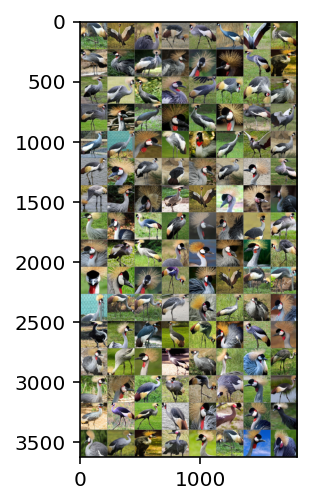

CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PIGEON CROWNED PI

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

###### Making RESNET34 from scratch

Basic Buidling Block of RESNET34 looks like this:<br>
1. A convolution block (Conv -> BN -> ReLU -> MaxPool)<br>
2. ResLayer - 1<br>
3. ResLayer - 2<br>
4. ResLayer - 3<br>
5. ResLayer - 4<br>
6. A classifier block with average Pooling and a Linear Layer


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class ResNet34(nn.Module):
  def __init__(self,num_classes=275):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#layer 1
# following block will be implemented 3 times
    self.conv1a = nn.Conv2d(64,64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn1a = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.conv1b = nn.Conv2d(64,64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn1b = nn.BatchNorm2d(64)

#layer 2
    self.conv2a = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    self.bn2a = nn.BatchNorm2d(128)
    self.relu = nn.ReLU(inplace=True)
    self.conv2b = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn2b = nn.BatchNorm2d(128)
    self.downsample2 = nn.Sequential(nn.Conv2d(64, 128, 1, 2, bias=False),nn.BatchNorm2d(128))
# following block will be implemented 3 times
    self.conv2c = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn2c = nn.BatchNorm2d(128)
    self.relu = nn.ReLU(inplace=True)
    self.conv2c = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn2c = nn.BatchNorm2d(128)
#layer 3
    self.conv3a = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    self.bn3a = nn.BatchNorm2d(256)
    self.relu = nn.ReLU(inplace=True)
    self.conv3b = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn3b = nn.BatchNorm2d(256)
    self.downsample3 = nn.Sequential(nn.Conv2d(128, 256, 1, 2, bias=False),nn.BatchNorm2d(256))
# following block will be implemented 5 times
    self.conv3b = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn3b = nn.BatchNorm2d(256)
    self.relu = nn.ReLU(inplace=True)
    self.conv3b = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn3b = nn.BatchNorm2d(256)
#layer 4
    self.conv4a = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    self.bn4a = nn.BatchNorm2d(512)
    self.relu = nn.ReLU(inplace=True)
    self.conv4b = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn4b = nn.BatchNorm2d(512)
    self.downsample4 = nn.Sequential(nn.Conv2d(256, 512, 1, 2, bias=False),nn.BatchNorm2d(512))
  # following block will be implemented 2 times
    self.conv4b = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn4b = nn.BatchNorm2d(512)
    self.relu = nn.ReLU(inplace=True)
    self.conv4b = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn4b = nn.BatchNorm2d(512)
# avg pooling and all:
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 , num_classes)

  def forward(self,x):
       
    x = self.conv1(x)           # input dimension = 224x224
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)         # output dimension = 112x112
    x = self.relu(x)
#layer #1 :
    identity = x
    out0 = self.conv1a(x)          # input dimension = 112x112
    out0 = self.bn1a(out0)
    out0 = self.relu(out0)
    out0 = self.conv1b(out0)
    out0 = self.bn1b(out0)
    out0 += identity
    out0 = self.relu(out0)

    identity = out0
    out1 = self.conv1a(out0)          
    out1 = self.bn1a(out1)
    out1 = self.relu(out1)
    out1 = self.conv1b(out1)
    out1 = self.bn1b(out1)
    out1 += identity
    out1 = self.relu(out1)

    identity = out1
    out2 = self.conv1a(out1)          
    out2 = self.bn1a(out2)
    out2 = self.relu(out2)
    out2 = self.conv1b(out2)
    out2 = self.bn1b(out2)            # output dimension = 112x112
    out2 += identity
    out2 = self.relu(out2)
#layer #2 :
    out3 = self.conv2a(out2)          # input dimension = 112x112
    out3 = self.bn2a(out3)
    out3 = self.relu(out3)
    out3 = self.conv2b(out3)
    out3 = self.bn2b(out3)
    
    identity = self.downsample2(out2)
    out3 += identity
    out3 = self.relu(out3)

    identity = out3
    out4 = self.conv2c(out3)
    out4 = self.bn2c(out4)
    out4 = self.relu(out4)
    out4 = self.conv2c(out4)
    out4 = self.bn2c(out4)
    out4 += identity
    out4 = self.relu(out4)

    identity = out4
    out5 = self.conv2c(out4)
    out5 = self.bn2c(out5)
    out5 = self.relu(out5)
    out5 = self.conv2c(out5)
    out5 = self.bn2c(out5)
    out5 += identity
    out5 = self.relu(out5)

    identity = out5
    out6 = self.conv2c(out5)
    out6 = self.bn2c(out6)
    out6 = self.relu(out6)
    out6 = self.conv2c(out6)
    out6 = self.bn2c(out6)
    out6 += identity
    out6 = self.relu(out6)
#layer #3 :
    out7 = self.conv3a(out6)          
    out7 = self.bn3a(out7)
    out7 = self.relu(out7)
    out7 = self.conv3b(out7)
    out7 = self.bn3b(out7)
    
    identity = self.downsample3(out6)
    out7 += identity 
    out7 = self.relu(out7)   
#1    
    identity = out7
    out8 = self.conv3b(out7)
    out8 = self.bn3b(out8)
    out8 = self.relu(out8)
    out8 = self.conv3b(out8)
    out8 = self.bn3b(out8)
    out8 += identity
    out8 = self.relu(out8)
#2
    identity = out8
    out9 = self.conv3b(out8)
    out9 = self.bn3b(out9)
    out9 = self.relu(out9)
    out9 = self.conv3b(out9)
    out9 = self.bn3b(out9)
    out9 += identity
    out9 = self.relu(out9)
#3
    identity = out9
    out10 = self.conv3b(out9)
    out10 = self.bn3b(out10)
    out10 = self.relu(out10)
    out10 = self.conv3b(out10)
    out10 = self.bn3b(out10)
    out10 += identity
    out10 = self.relu(out10)
#4
    identity = out10
    out11 = self.conv3b(out10)
    out11 = self.bn3b(out11)
    out11 = self.relu(out11)
    out11 = self.conv3b(out11)
    out11 = self.bn3b(out11)
    out11 += identity
    out11 = self.relu(out11)
#5
    identity = out11
    out12 = self.conv3b(out11)
    out12 = self.bn3b(out12)
    out12 = self.relu(out12)
    out12 = self.conv3b(out12)
    out12 = self.bn3b(out12)
    out12 += identity
    out12 = self.relu(out12)
#layer #4 :
    out13 = self.conv4a(out12)          
    out13 = self.bn4a(out13)
    out13 = self.relu(out13)
    out13 = self.conv4b(out13)
    out13 = self.bn4b(out13)
    
    identity = self.downsample4(out12)
    out13 += identity
    out13 = self.relu(out13)
#1
    identity = out13
    out14 = self.conv4b(out13)
    out14 = self.bn4b(out14)
    out14 = self.relu(out14)
    out14 = self.conv4b(out14)
    out14 = self.bn4b(out14)
    out14 += identity
    out14 = self.relu(out14)
#2    
    identity = out14
    out15 = self.conv4b(out14)
    out15 = self.bn4b(out15)
    out15 = self.relu(out15)
    out15 = self.conv4b(out15)
    out15 = self.bn4b(out15)
    out15 += identity
    out15 = self.relu(out15)           
        
# Average Pooling and all:
    out = self.avgpool(out15)
    out = torch.flatten(out, 1)
    out = self.fc(out)

    return out

In [ ]:
model = ResNet34().to('cuda')

In [ ]:
model

ResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [ ]:
EPOCHS = 20
for epoch in range(EPOCHS):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i%100 == 0 and i > 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
            running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
            
print('Training Done')
torch.save(model, 'myRESmodel[2].pth')

Loss [1, 100](epoch, minibatch):  6.02075175523758
Loss [1, 200](epoch, minibatch):  7.553121843338013
Loss [1, 300](epoch, minibatch):  8.956519451141357
Loss [2, 100](epoch, minibatch):  5.012391366958618
Loss [2, 200](epoch, minibatch):  6.332391605377198
Loss [2, 300](epoch, minibatch):  7.463676676750183
Loss [3, 100](epoch, minibatch):  5.0140257477760315
Loss [3, 200](epoch, minibatch):  5.929670386314392
Loss [3, 300](epoch, minibatch):  7.18494345664978
Loss [4, 100](epoch, minibatch):  5.057010922431946
Loss [4, 200](epoch, minibatch):  5.708274574279785
Loss [4, 300](epoch, minibatch):  6.175284461975098
Loss [5, 100](epoch, minibatch):  5.166777458190918
Loss [5, 200](epoch, minibatch):  5.642795720100403
